## Import modules

In [24]:
import os
import torch
import pandas as pd
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from random import random, randrange
from torchvision import transforms,models
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
from copy import deepcopy
import matplotlib.image as mpimg

## Import fashion clip model

In [2]:
model_name = "patrickjohncyh/fashion-clip"
image_processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

## Creating images lists

In [3]:
CLEAN_IMAGES_CSV_PATH = os.path.join("data","DAM")
reference_images = [os.path.join(CLEAN_IMAGES_CSV_PATH, img)for img in os.listdir(CLEAN_IMAGES_CSV_PATH)]

TEST_IMAGES_PATH = os.path.join("data","test_image_headmind")
img_list = [os.path.join(TEST_IMAGES_PATH,i) for i in os.listdir(TEST_IMAGES_PATH)]

## Creating Answers Directory

In [4]:
csv_all = pd.read_csv("results17-32.csv",header=None, sep=", ")
csv_arthur = pd.read_csv("answer65-80.csv", header=None, sep=", ")
csv_all = pd.concat([pd.read_csv("answers1-16.csv", header=None, sep= ", "),csv_all, pd.read_csv("results33-48.csv", header=None, sep=", "), pd.read_csv("results49-64.csv", header=None, sep=", "), csv_arthur])
csv_all.head()
csv_all.columns = ['0','1']

C:\Users\arthu\AppData\Local\Temp\ipykernel_8444\4145771647.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  csv_all = pd.read_csv("results17-32.csv",header=None, sep=", ")
C:\Users\arthu\AppData\Local\Temp\ipykernel_8444\4145771647.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  csv_arthur = pd.read_csv("answer65-80.csv", header=None, sep=", ")
C:\Users\arthu\AppData\Local\Temp\ipykernel_8444\4145771647.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can 

In [5]:
csv_all

,0,1
0,M0538OCALM35R,image-20210928-102713-12d2869d
1,M0505SLOIM989,image-20210928-102718-2474636a
2,M0565ONGEM50P,image-20210928-102721-8eaea48f
3,M9203UWDIM59E,image-20210928-102725-7e28b44c
4,M9204UMOAM918,image-20210928-102725-7e28b44c
...,...,...
12,SOSTELAIR1SZJ86,MicrosoftTeams-image_46
13,SOSTELAIR1807YB,MicrosoftTeams-image_48
14,DSGTS6UXR10A0,MicrosoftTeams-image_50
15,S5652CBAAM41G,MicrosoftTeams-image_53


In [6]:
answers = {}
for _, row in csv_all.iterrows():
    if row['1'] in answers.keys():
        answers[row['1']].append(row['0'])
    else:
        answers[row['1']] = [row['0']]

## Creating embeddings for the referrence images

In [7]:
reference_features = []
for img in tqdm(reference_images):
    image = Image.open(img).convert("RGB")
    inputs = image_processor(images=image, return_tensors="pt", padding=True)
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
        embedding = embedding / embedding.norm(p=2, dim=-1)
        reference_features.append(embedding)

  0%|          | 0/2766 [00:00<?, ?it/s]

100%|██████████| 2766/2766 [06:20<00:00,  7.27it/s]


In [8]:
client_features = []
for img in tqdm(img_list):
    image = Image.open(img).convert("RGB")
    inputs = image_processor(images=image, return_tensors="pt", padding=True)
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
        embedding = embedding / embedding.norm(p=2, dim=-1)
        client_features.append(embedding)

100%|██████████| 80/80 [00:43<00:00,  1.85it/s]


In [9]:
for i in range(len(reference_features)):
    reference_features[i] = reference_features[i].flatten()

for i in range(len(client_features)):
    client_features[i] = client_features[i].flatten()

In [52]:
client_embedding_tensor = torch.stack(client_features).squeeze(1)
embedding_tensor = torch.stack(reference_features).squeeze(1)

cosine_similarities = torch.mm(client_embedding_tensor, embedding_tensor.t())

closest_indices = torch.argsort(cosine_similarities, dim=1,descending=True)[:,:11]
closest_indices

tensor([[1666, 1775, 2522, 1719, 2087, 1739, 1696, 1772, 1656, 1657, 1763],
        [1735, 1716, 1768,  910, 1717, 1779, 2523, 1783, 1816, 1817, 1839],
        [1696, 2087, 1710, 1778, 1822, 1788, 2522, 1767, 1780, 1766, 1763],
        [2265, 2281, 2245, 2581, 2269, 2299, 2255, 2247, 2263, 2243, 2294],
        [2265, 2281, 2288, 2581, 2269, 2243, 2263, 2255, 2235, 2245, 2272],
        [1426, 1492, 1420, 1376, 1431,  300, 1343, 1185, 1196, 1386, 1469],
        [2287, 2464, 2299, 2249, 2614, 2227, 2146, 2266, 2582, 2419, 2625],
        [1817, 1735, 2523, 1768,  910, 1717,  911, 1818, 1688, 1839, 1902],
        [2651, 2644, 2635, 1828, 1934, 2636, 1827, 1914, 2543, 1915, 1970],
        [2651, 1934, 1828, 2635, 1827, 1928, 1914, 1929, 1918, 1960, 2652],
        [ 659,  664,  660, 1057, 1170, 1078, 1172,  663, 2748, 1056, 2339],
        [1574, 1539, 1591, 1994, 2001, 2542, 1533, 1547, 2002, 2297, 1993],
        [ 665, 1035, 2744, 2736, 1050,  659, 1036, 1030,  664, 1078, 2743],
        [274

In [53]:
guesses = {}

for i, img in enumerate(img_list):
    file_name = img.split("\\")[-1]
    img_id = file_name.split(".")[0]
    guesses[img_id] = [reference_images[ind] for ind in closest_indices[i].tolist()]

In [54]:
accuracy = 0
nb_guess = 0
for answer_key in answers.keys():
    found = 0
    if answer_key in guesses.keys():
        nb_guess += 1
        for value_guess in guesses[answer_key]:
            for value_answ in answers[answer_key]:
                if value_answ in value_guess and not found:
                    accuracy += 1
                    found = 1

accuracy/nb_guess*100

90.9090909090909

### Displaying predictions

In [35]:
mpimg.imread(img_path).shape

(3024, 4032, 3)

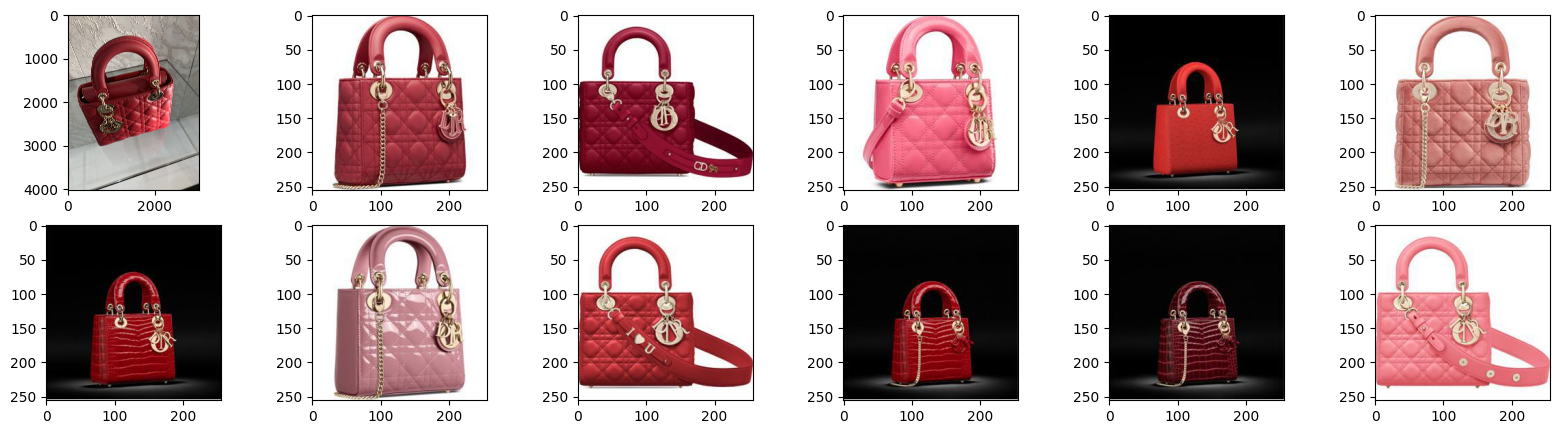

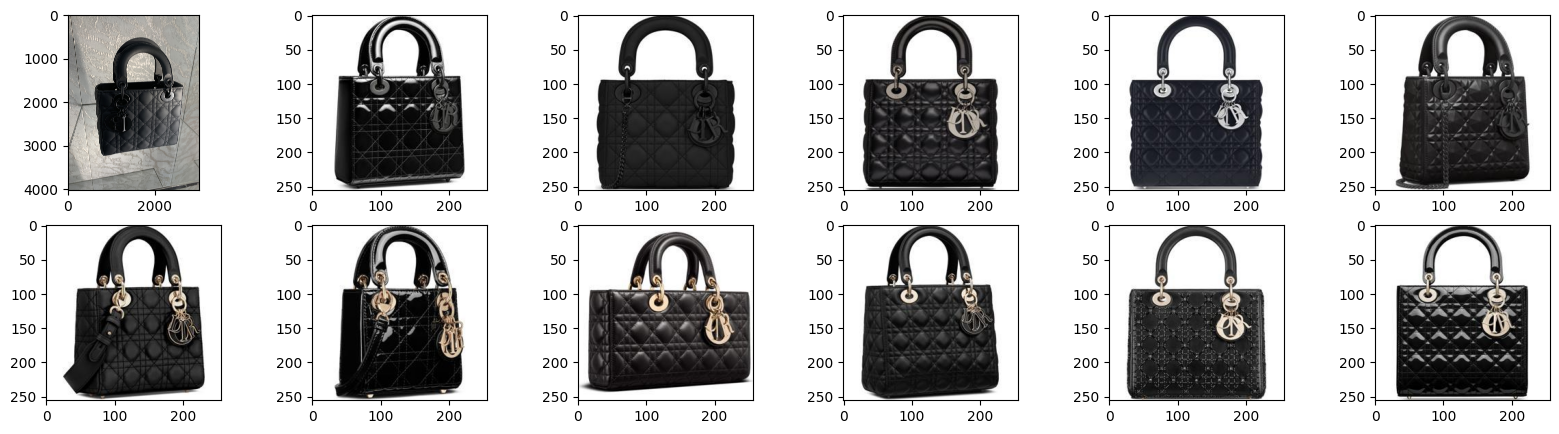

In [63]:
for i,img_path in enumerate(img_list):

    if i > 1:
        break
    file_name = img_path.split("\\")[-1]
    img_id = file_name.split(".")[0]
    guess_list = []
    for g in guesses[img_id]:
        guess_list.append(g)

    fig, axs = plt.subplots(2,6,figsize=(20,5))
    fig
    axs[0,0].imshow(np.swapaxes(mpimg.imread(img_path),0,1))
    for j in range(1,12):
        axs[int(j/6),int(j%6)].imshow(mpimg.imread(guess_list[j-1]))